In [502]:
import numpy as np
import scipy.stats as sts
import scipy.special as spec
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.integrate as integral
import pandas as pd
import statsmodels.api as sm
import numpy.linalg as lin
%matplotlib notebook

### Deterministic Version
#### Since we don't have shock in deterministic case, we use general method of moment rather than simulated method of moment

In [503]:
#input data
dt = pd.read_excel('data.xlsx')
dt.head()

,quarter,Inflation,interest rate,Output Gap
0,1,2.1,3.933333,3.893743
1,2,1.8,3.696667,3.779925
2,3,1.2,2.936667,3.817533
3,4,1.0,2.296667,1.594366
4,5,0.8,2.003333,0.297382


In [504]:
#defined model function to simulate model data
S = 2200
alpha_pi = 1
gamma = 0
def model(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y):
    interest_rate_lag = 3.99
    b = np.zeros(S)
    pi_c = np.zeros(S)
    pi_c[0] = 2.23
    b[0] = 0.5
    
    
    interest_rate = np.zeros(S)
    pi = np.zeros(S)
    y = np.zeros(S)
    
    for i in range(S):
        y[i] = eta*b[i]
        pi[i] = pi_c[i] + kappa*y[i]
        interest_rate[i] = mu_i * interest_rate_lag + (1-mu_i) * (5 + mu_pi * (pi[i] - 2.5) + mu_y * y[i])
        
        if i < S-1:
            pi_c[i+1] = pi_c[i] + alpha_pi * (gamma*2.5 + (1-gamma) * pi[i] - pi_c[i])
            
            f = sai_b*b[i] - sai_i*(interest_rate[i] - pi[i] - 2.5)
            probnp = min(1,0.125*np.exp(f))
            probpn = min(1,0.125*np.exp(-f))
            b[i+1] = b[i] + (1-b[i])*probnp - (1+b[i])*probpn
        
        interest_rate_lag = interest_rate[i]
        
    return y[200:], pi[200:], interest_rate[200:]

In [505]:
#compute model moment
def model_mom(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y):
    y_mod, pi_mod, i_mod = model(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y)
    
    y_mod_mean = y_mod.mean()
    y_mod_std = y_mod.std()
    
    pi_mod_mean = pi_mod.mean()
    pi_mod_std = pi_mod.std()
    
    i_mod_mean = i_mod.mean()
    i_mod_std = i_mod.std()
    
    yi_mod_cov = np.cov(y_mod, i_mod)
    ypi_mod_cov = np.cov(y_mod, pi_mod)
    ipi_mod_cov = np.cov(i_mod, pi_mod)
    
    yylag_mod_cov = np.cov(y_mod[1:2000], y_mod[:2000-1])
    iilag_mod_cov = np.cov(i_mod[1:2000], i_mod[:2000-1])
    pplag_mod_cov = np.cov(pi_mod[1:2000], pi_mod[:2000-1])
    
    return np.array([y_mod_mean, y_mod_std, pi_mod_mean, pi_mod_std, i_mod_mean, i_mod_std, yi_mod_cov[0][1],\
           ypi_mod_cov[0][1], ipi_mod_cov[0][1], yylag_mod_cov[0][1], iilag_mod_cov[0][1], pplag_mod_cov[0][1]])

In [506]:
#compute data moment
dt_y = dt['Output Gap'].values
dt_p = dt.Inflation.values
dt_i = dt['interest rate'].values

y_dat_mean = dt_y.mean()
y_dat_std = dt_y.std()

pi_dat_mean = dt_p.mean()
pi_dat_std = dt_p.std()

i_dat_mean = dt_i.mean()
i_dat_std = dt_i.std()

yi_dat_cov = np.cov(dt_y, dt_i)
ypi_dat_cov = np.cov(dt_y, dt_p)
ipi_dat_cov = np.cov(dt_i, dt_p)

yylag_dat_cov = np.cov(dt_y[1:78], dt_y[:78-1])
iilag_dat_cov = np.cov(dt_i[1:78], dt_i[:78-1])
pplag_dat_cov = np.cov(dt_p[1:78], dt_p[:78-1])

data_mom = np.array([y_dat_mean, y_dat_std, pi_dat_mean, pi_dat_std, i_dat_mean, i_dat_std, yi_dat_cov[0][1],\
           ypi_dat_cov[0][1], ipi_dat_cov[0][1], yylag_dat_cov[0][1], iilag_dat_cov[0][1], pplag_dat_cov[0][1]])

In [507]:
#Compute the error vector
def err_vec(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y):
    m_mom = model_mom(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y)
    err = m_mom - data_mom
    
    return err

In [508]:
#Compute criterion function
def crit(params, *args):
    sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y = params
    W_hat = args
    
    err = err_vec(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y)
    
    crit_val = np.dot(np.dot(err.T, W_hat), err)
    
    return crit_val

#### Since the way that the original paper used to construct the weighting matrix is too difficult, we use Iterated variance covariance estimator of W instead

In [509]:
# Since we want to use the Iterated variance covariance estimator, then we first estimate the
# parameters by using the Identity Matrix
W_Id = np.eye(12)
sai_b_init = 0.726
sai_i_init = 3
eta_init = 1.841
kappa_init =  0.243
mu_i_init = 0.717
mu_pi_init = 1.481
mu_y_init = 0.627

params_init = np.array([sai_b_init, sai_i_init, eta_init, kappa_init, mu_i_init, mu_pi_init, mu_y_init])
W_hat = W_Id

results = opt.minimize(crit, params_init, args=(W_hat), method='L-BFGS-B',bounds=((0, 5), (1e-2, 15),(1e-2,None),\
                                                                                  (1e-2,1),(0,1),\
                                                                                  (1e-2,4),(1e-2,5)))

In [510]:
results

      fun: array([ 31.43154584])
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.74094869e+00,   3.33401218e+00,   5.48003243e+00,
        -1.14479109e+02,   2.22701379e+05,   6.39770661e+01,
         5.55270972e+01])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 640
      nit: 9
   status: 2
  success: False
        x: array([ 0.81763789,  2.93586547,  2.54098987,  0.26857471,  0.73481804,
        1.44646569,  0.61165026])

In [514]:
sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y = results.x
params_init1 = np.array([sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y])


VCV = np.outer(err_vec(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y),\
               err_vec(sai_b, sai_i, eta, kappa, mu_i, mu_pi, mu_y)) / 78

W_hat1 = lin.pinv(VCV)

In [515]:
results1 = opt.minimize(crit, params_init, args=(W_hat1), method='L-BFGS-B',bounds=((0, 5), (1e-2, 15),(1e-2,None),\
                                                                                  (1e-2,1),(0,1),\
                                                                                  (1e-2,4),(1e-2,5)))
results1

      fun: array([  9.11522470e-13])
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.01169077e-05,   5.81880040e-06,  -1.54827264e-05,
        -7.89645323e-05,  -7.36967572e-06,   5.15498698e-04,
         4.95097261e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 312
      nit: 14
   status: 0
  success: True
        x: array([ 1.56961821,  2.40955071,  1.49210943,  0.44223509,  0.73932788,
        1.18421259,  0.51051657])

In [518]:
y,pi,i = model(1.56961821,  2.40955071,  1.49210943,  0.44223509,  0.73932788,
        1.18421259,  0.51051657)

In [519]:
x = list(range(200))
y

array([ 1.48650817,  1.48463361,  1.48210978, ..., -1.48673927,
       -1.48494519, -1.4825301 ])

<IPython.core.display.Javascript object>


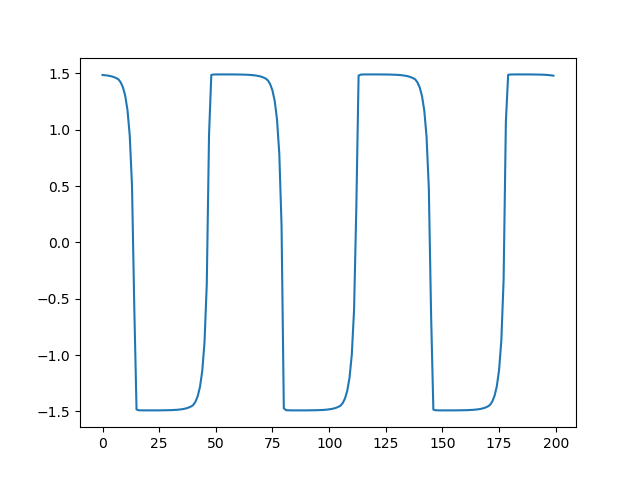

In [520]:
plt.plot(x,y[:200])
plt.show()